<a href="https://colab.research.google.com/github/sruthiscodes/capstone/blob/main/Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install mne


  Using cached mne-1.9.0-py3-none-any.whl.metadata (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.0 MB/s eta 0:00:00


In [6]:
!pip install mne pywavelets matplotlib numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.6 MB/s eta 0:00:00


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
import pywt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [8]:
np.random.seed(42)

In [9]:
subjects = range(1,2)
runs = [4, 8, 12]

#preprocessing parameters
samplingFreq = 160
lowFreq = 0.5
highFreq = 45
notchFreq = 60
tMin, tMax = 0, 4

In [10]:
def loadEEG(subject, runs):
  filePaths = eegbci.load_data(subject, runs)
  print(f"Loading data for subject {subject}")
  rawlist = []

  for file in filePaths:
    raw = read_raw_edf(file, preload=True)
    rawlist.append(raw)

  if len(rawlist) > 1:
    raw = mne.concatenate_raws(rawlist)
  else:
    raw = rawlist[0]

  rename_dict = {
        'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2', 'Fc4.': 'FC4', 'Fc6.': 'FC6',
        'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1', 'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6',
        'Cp5.': 'CP5', 'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4', 'Cp6.': 'CP6',
        'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7', 'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8',
        'F7..': 'F7', 'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2', 'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8',
        'Ft7.': 'FT7', 'Ft8.': 'FT8', 'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7', 'Tp8.': 'TP8',
        'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1', 'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
        'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8', 'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
    }
  raw.rename_channels(rename_dict)

  montage = mne.channels.make_standard_montage('standard_1020')
  raw.set_montage(montage)

  events, eventID = mne.events_from_annotations(raw)
  raw.filter(l_freq = lowFreq, h_freq = highFreq)
  raw.notch_filter(freqs = notchFreq)

  eventID = dict(T1 = 1, T2 = 2)
  epochs = mne.Epochs(raw, events, eventID, tmin=tMin, tmax=tMax, baseline=None, preload=True)
  return raw, epochs, events, eventID

In [11]:
def cwt(signal, scales, wavelet='morl'):
    coeffs, freqs = pywt.cwt(signal, scales, wavelet)
    return coeffs

In [12]:
def extractFeatures(epochs, scales):
    X = []
    y = []
    data = epochs.get_data()
    labels = epochs.events[:, -1]

    print("Extracting features")
    for i, epoch in enumerate(data):
        features = []
        for channel in epoch:
            # Apply CWT
            coeffs = cwt(channel, scales)
            # Extract statistics from coefficients
            mean = np.mean(coeffs, axis=1)
            std = np.std(coeffs, axis=1)

            # Concatenate the statistics for this channel
            channelFeatures = np.concatenate([mean, std])
            # Add to the list of features (using list append, not numpy append)
            features.append(channelFeatures)

        # Convert list of channel features to flat array
        features = np.concatenate(features)  # Changed from np.array(features).flatten()

        # Add to our collection
        X.append(features)
        y.append(labels[i])

    X = np.array(X)
    y = np.array(y)

    return {'features': X, 'labels': y}

In [13]:
# Initialize data storage
allFeatures = []
allLabels = []

# Process each subject individually
for subject in subjects:
    try:
        print(f"\n{'='*50}\nProcessing subject {subject}\n{'='*50}")

        # Load EEG data for current subject
        raw, epochs, events, eventID = loadEEG(subject, runs)

        # Print basic information about the loaded data
        print(f"Subject {subject} data loaded successfully")
        print(f"Number of channels: {len(raw.ch_names)}")
        print(f"Number of epochs: {len(epochs)}")
        print(f"Sampling frequency: {raw.info['sfreq']} Hz")
        print(f"Duration: {raw.times.max()} seconds")

        # Define wavelet scales
        scales = np.arange(1, 128)

        # Extract features for the current subject
        features = extractFeatures(epochs, scales)
        allFeatures.append(features['features'])
        allLabels.append(features['labels'])

        print(f"Features extracted for subject {subject}")
        print(f"Feature shape: {features['features'].shape}")
        print(f"Labels: {np.unique(features['labels'], return_counts=True)}")

    except Exception as e:
        print(f"Error processing subject {subject}: {e}")
        continue


Processing subject 1
Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 36s (7.4 MB)
Loading data for subject 1
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting u

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
68 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 1 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Extracting features
Features extracted for subject 1
Feature shape: (68, 16256)
Labels: (array([1, 2]), array([45, 23]))


Created directory: ./eeg_data
Saved features to ./eeg_data/X_cwt.npy
Saved labels to ./eeg_data/y_cwt.npy

Processing complete!
Features shape: (68, 16256)
Labels shape: (68,)
Unique labels: [1 2]
Label counts: [45 23]
Saved class distribution plot to ./eeg_data/class_distribution.png


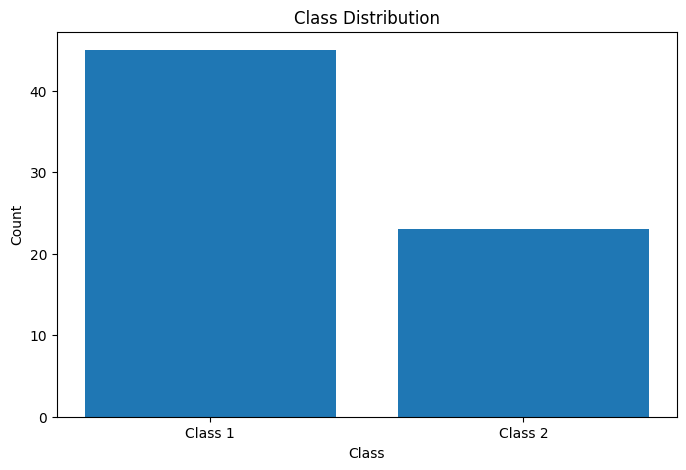

In [14]:
if not os.path.exists('./eeg_data'):
    os.makedirs('./eeg_data')
    print("Created directory: ./eeg_data")

X = np.vstack(allFeatures) if allFeatures else np.array([])
y = np.concatenate(allLabels) if allLabels else np.array([])

if X.size > 0 and y.size > 0:
    np.save('./eeg_data/X_cwt.npy', X)
    np.save('./eeg_data/y_cwt.npy', y)
    print(f"Saved features to ./eeg_data/X_cwt.npy")
    print(f"Saved labels to ./eeg_data/y_cwt.npy")
else:
    print("No features or labels to save. Check if feature extraction was successful.")

print("\nProcessing complete!")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

if y.size > 0:
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Unique labels: {unique_labels}")
    print(f"Label counts: {counts}")

    plt.figure(figsize=(8, 5))
    plt.bar(['Class ' + str(c) for c in unique_labels], counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.savefig('./eeg_data/class_distribution.png')
    print("Saved class distribution plot to ./eeg_data/class_distribution.png")
    plt.show()

Unique labels after resampling: [1 2]
Label counts after resampling: [45 45]
Saved resampled features to ./eeg_data/X_resampled.npy
Saved resampled labels to ./eeg_data/y_resampled.npy
Saved resampled class distribution plot to ./eeg_data/resampled_class_distribution.png


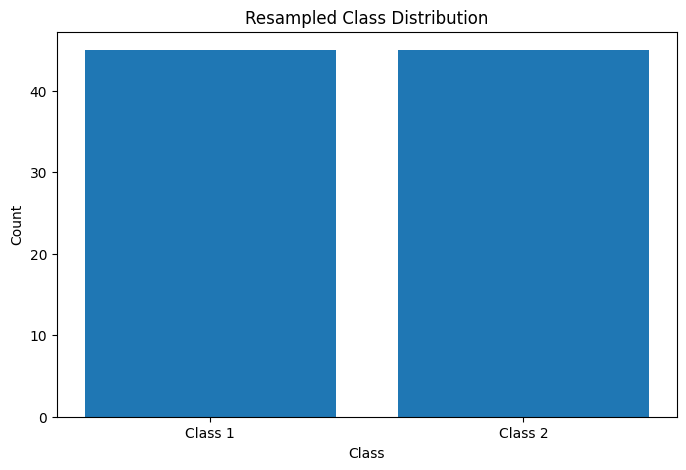

In [15]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

unique_labels_resampled, counts_resampled = np.unique(y_resampled, return_counts=True)

print(f"Unique labels after resampling: {unique_labels_resampled}")
print(f"Label counts after resampling: {counts_resampled}")

np.save('./eeg_data/X_resampled.npy', X_resampled)
np.save('./eeg_data/y_resampled.npy', y_resampled)
print(f"Saved resampled features to ./eeg_data/X_resampled.npy")
print(f"Saved resampled labels to ./eeg_data/y_resampled.npy")


plt.figure(figsize=(8, 5))
plt.bar(['Class ' + str(c) for c in unique_labels_resampled], counts_resampled)
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('./eeg_data/resampled_class_distribution.png')
print("Saved resampled class distribution plot to ./eeg_data/resampled_class_distribution.png")
plt.show()

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt

# 1️⃣ Plot Raw EEG Signal
def plot_raw_eeg(raw, channel=0, seconds=5):
    sfreq = int(raw.info['sfreq'])
    data, _ = raw[:, :seconds * sfreq]
    time = np.linspace(0, seconds, data.shape[1])

    plt.figure(figsize=(10, 4))
    plt.plot(time, data[channel], label=raw.ch_names[channel], color='b')
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Raw EEG Signal")
    plt.legend()
    plt.show()


# 2️⃣ Improved Visualize CWT Scalogram with Better Color Contrast
def plot_cwt_scalogram(signal, scales, wavelet='morl', fs=256):
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)

    # Normalize the coefficients for better contrast
    coeffs = np.abs(coeffs)
    coeffs /= np.max(coeffs)  # Normalize between 0 and 1

    plt.figure(figsize=(10, 5))
    plt.imshow(coeffs, aspect='auto', extent=[0, len(signal), scales[-1], scales[0]], cmap='inferno', interpolation='bilinear')

    plt.yscale("log")  # Log-scale for better frequency separation
    plt.colorbar(label="Normalized Magnitude")
    plt.xlabel("Time")
    plt.ylabel("Scale (Log)")
    plt.title("CWT Scalogram with Improved Contrast")
    plt.show()

# 3️⃣ Compare CWT Across EEG Bands
def compare_cwt_bands(signal, scales, wavelet='morl'):
    bands = {
        "Delta (0.5-4Hz)": (1, 4),
        "Theta (4-8Hz)": (5, 8),
        "Alpha (8-12Hz)": (9, 12),
        "Beta (12-30Hz)": (13, 30),
        "Gamma (30-45Hz)": (31, 45)
    }

    fig, axes = plt.subplots(len(bands), 1, figsize=(10, 12))
    for ax, (band, (low, high)) in zip(axes, bands.items()):
        selected_scales = [s for s in scales if low <= s <= high]
        coeffs, _ = pywt.cwt(signal, selected_scales, wavelet)
        ax.imshow(np.abs(coeffs), aspect='auto', cmap='jet')
        ax.set_title(band)
        ax.set_ylabel("Scale")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

# 4️⃣ Heatmap of CWT Features Across Channels
def plot_cwt_heatmap(features, ch_names):
    plt.figure(figsize=(12, 6))
    sns.heatmap(features, cmap='viridis', xticklabels=ch_names, yticklabels=False)
    plt.xlabel("Channels")
    plt.ylabel("Feature Index")
    plt.title("CWT Feature Heatmap")
    plt.show()


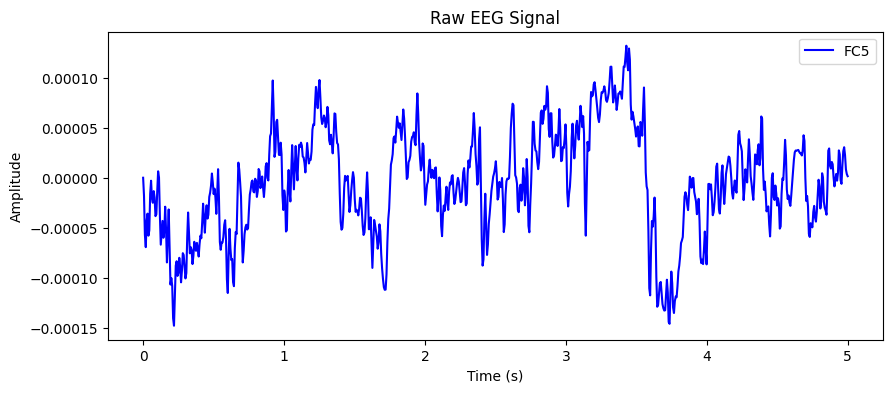

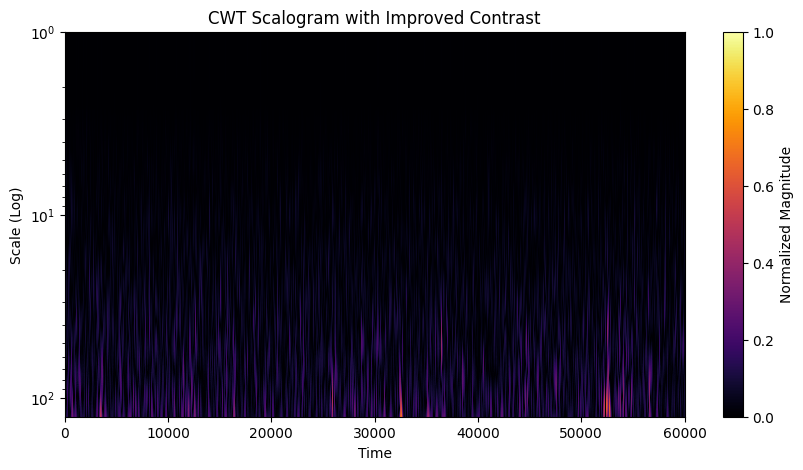

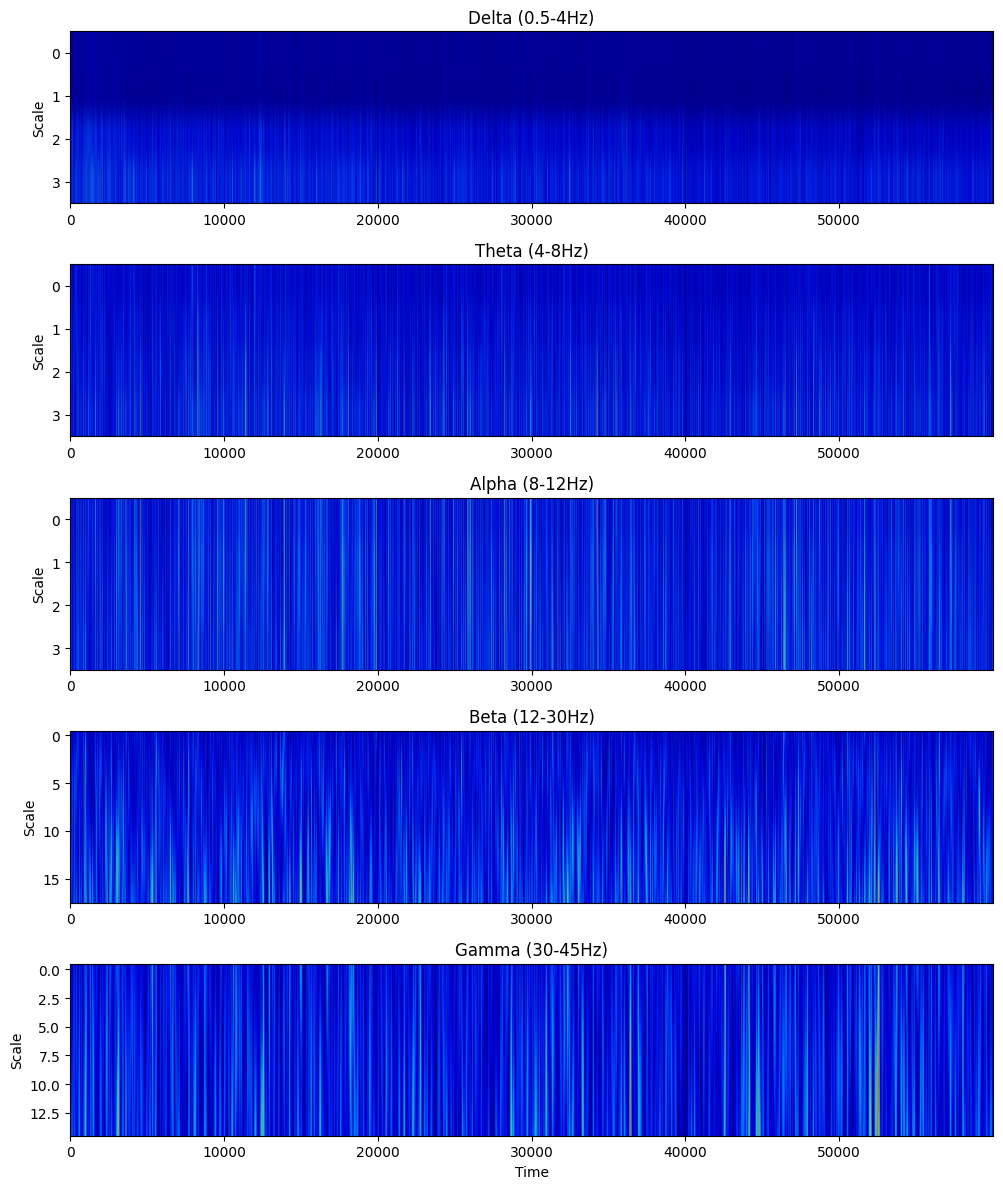

In [20]:
# Ensure raw EEG data is loaded
plot_raw_eeg(raw, channel=0, seconds=5)

# Select a sample EEG signal (e.g., first channel)
signal = raw.get_data()[0]  # First channel
scales = np.arange(1, 128)  # Adjust based on sampling rate

# Plot CWT scalogram
plot_cwt_scalogram(signal, scales, wavelet='morl')

# Compare CWT across EEG bands
compare_cwt_bands(signal, scales, wavelet='morl')

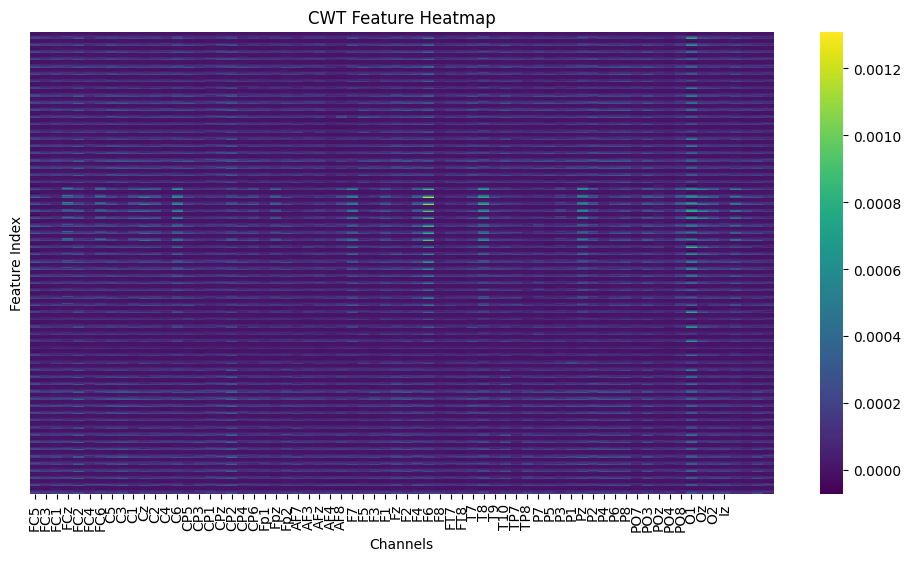

In [18]:
features_2d = np.squeeze(np.array(allFeatures)).T  # Remove singleton dimension
plot_cwt_heatmap(features_2d, raw.ch_names)
